# 10. LLM으로 ETF 이해하기

- 백테스팅 결과를 LLM을 통해 더 잘 이해해 보자.
- 다만 LLM의 단점은 최신 정보는 학습되어 있지 않고, 잘못된 정보를 생성할 수도 있다는 점
    - 이걸 외부 도구(tool)을 연결해 보완할 수 있다. 그 중 하나가 웹 검색
- OpenAI API에서 웹 검색 tool 사용해 백테스팅 결과와 결합해서, 관심있는 ETF 종목을 더 깊게 이해해 보자.

## 0. API KEY, 모델 클라이언트 준비

In [ ]:
!pip install --upgrade openai

In [1]:
import json
import pprint
import pandas as pd
import os
from openai import OpenAI
from anthropic import Anthropic
from pathlib import Path
from datetime import datetime
import bt

# set up config
from config.config_loader import config, openai_client

config_kis = config.get("kis")
url_base = config_kis.get("url_base")
app_key = config_kis.get("app_key")
app_secret = config_kis.get("app_secret")
custtype = config_kis.get("custtype")

In [2]:
# 분석 대상 데이터 저장 경로
data_path = "data"
os.makedirs(data_path, exist_ok=True)

with open(data_path + "/filtered_etf_list.json", "r", encoding="utf-8") as f:
    etf_list = json.load(f)

# 생성한 보고서 저장 경로: 10강 보고서 폴더 생성
report_path = "report/10"
os.makedirs(report_path, exist_ok=True)

## 분석 1. [주식형 ETF] 종목 지표 해설, 장단점 분석

- 분석 대상: [069500] Kodex 200 (코스피 200 지수 추종)

In [3]:
# KIS API 통해 가져온 ETF 데이터 가져오기
df_KOSPI200 = pd.read_csv(data_path + "/069500/NAV.csv", index_col=0, parse_dates=True)

df_KOSPI200.head()

,Close
Date,
2002-10-14,5167
2002-10-15,5294
2002-10-16,5314
2002-10-17,5387
2002-10-18,5621


### (1) 백테스팅 실행

In [4]:
s = bt.Strategy(
    "Buy and hold",
    [
        bt.algos.RunOnce(),
        bt.algos.SelectAll(),
        bt.algos.WeighEqually(),
        bt.algos.Rebalance(),
    ],
)

test = bt.Backtest(s, df_KOSPI200, name="069500")
res = bt.run(test)
res.set_riskfree_rate(0.025) 
res.display()

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.08it/s]

Stat                 069500
-------------------  ----------
Start                2002-10-13
End                  2025-07-28
Risk-free rate       2.50%

Total Return         735.58%
Daily Sharpe         0.44
Daily Sortino        0.71
CAGR                 9.76%
Max Drawdown         -52.64%
Calmar Ratio         0.19

MTD                  3.79%
3m                   28.13%
6m                   29.74%
YTD                  37.13%
1Y                   17.70%
3Y (ann.)            12.63%
5Y (ann.)            9.85%
10Y (ann.)           8.01%
Since Incep. (ann.)  9.76%

Daily Sharpe         0.44
Daily Sortino        0.71
Daily Mean (ann.)    11.70%
Daily Vol (ann.)     20.94%
Daily Skew           -0.06
Daily Kurt           8.66
Best Day             14.95%
Worst Day            -11.87%

Monthly Sharpe       0.44
Monthly Sortino      0.79
Monthly Mean (ann.)  10.87%
Monthly Vol (ann.)   18.94%
Monthly Skew         -0.12
Monthly Kurt         0.68
Best Month           15.38%
Worst Month          -19.37

<Axes: title={'center': 'Equity Progression'}>

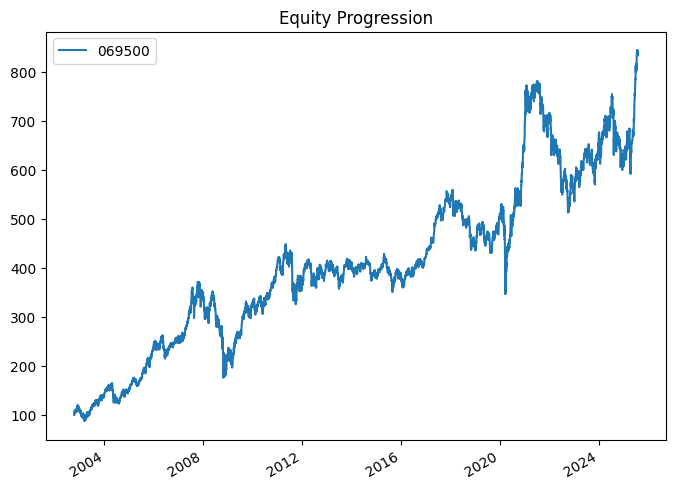

In [5]:
res.plot(figsize=(8, 6))

### (2) 프롬프트 준비 - 종목 상세 분석

- 백테스팅 결과에 더해, 웹 검색 결과까지 반영해 최신 시장 동향을 고려한 종목 분석이 가능하도록 하자.
- 오늘 날짜, 종목코드, 종목 기본정보, 백테스팅 결과를 dict 형식으로 저장한다.
- 이 변수들을 프롬프트 작성에 활용한다.

In [6]:
# (1) 오늘 날짜
today = datetime.now().strftime("%Y-%m-%d")
# (2) 종목코드
ticker = "069500"
# (3) ETF 기본정보
etf_info = etf_list[ticker]
name = etf_info["한글종목약명"]
# (4) 백테스팅 결과 후처리
backtest_result = res.__dict__["stats"]  # 백테스팅 결과 DataFrame으로 추출

# (5) dict로 저장
prompt_vars_stock = {
    "today": today,
    "ticker": ticker,
    "name": name,
    "etf_info": etf_info,
    "backtest_result": backtest_result,
}

In [7]:
DEV_PROMPT = """당신은 전문 펀드 매니저로서, ETF 투자에 대해 깊이 있는 분석과 실질적인 조언을 제공합니다.
프롬프트에 주어진 정보와 최신 웹 검색(한국거래소 상장 ETF 및 관련 이슈)에 기반하여, 입문 수준의 투자자를 대상으로 논리적이고 신뢰할 수 있는 답변을 작성하세요.
예상 독자는 기본적인 투자 용어에는 친숙하지만, 실제 투자 경험은 부족한 일반인입니다.

# 출력 형식

- 답변은 항상 한국어로 작성하고, Markdown 형식을 활용해 체계화합니다.
- 분석 결과는 한국어 문단과 표, 목록을 적절히 활용해 시각화합니다.
- 외국어 자료는 한국어로 정확히 전달(전문 용어 등은 원문 병기)하고, 전문 용어는 풀어서 설명합니다.

# 주의사항

- 데이터·뉴스 인용 시 반드시 시점과 수치를 명시하고, 구식 자료는 사용하지 않으며, 기사 인용은 최신 기사(출처/날짜)만 사용합니다.
- ETF의 장단점, 전략, 시장 동향, 과세 정보 등은 최신 검색 결과와 공식 데이터(출처/날짜 표기)에 기반해 제시하고, 불확실하거나 확인되지 않은 정보는 명확히 구분합니다.
- 수치나 최신 정보의 부족으로 인해 분석에 한계가 있다면 항상 명시합니다.

**중요**: 보고서 작성의 핵심 목적은 초보 투자자에게 최신 데이터와 분석을 바탕으로 한 ETF 투자 조언을 제공하는 것입니다. 전문성과 정확성을 유지하며, 항상 시각적으로 조직된 출력 및 명확한 출처 표기를 준수합니다.
개인적 의견이나 일반화된 조언은 피하고, 객관적이고 과학적인 분석을 우선시합니다. 투자 결정 책임은 독자에게 있음을 마지막에 간략히 명시합니다."""

USER_PROMPT_STOCK = f"""한국거래소에 상장된 다음 주식형 ETF 종목의 기본정보, 수익률, 지표 데이터를 바탕으로 분석 보고서를 작성해 주세요.

<info_list>
- 오늘 날짜: {prompt_vars_stock["today"]}
- 종목명: [{prompt_vars_stock["ticker"]}] {prompt_vars_stock["name"]}
- 기본정보:
```JSON
{prompt_vars_stock["etf_info"]}
```
- 상장일부터 오늘까지 백테스팅 결과:
```markdown
{prompt_vars_stock["backtest_result"]}
```
</info_list>

최종적으로 A4 1페이지 내외 분량의 보고서를 작성해주세요. 대략적으로 다음과 같은 섹션을 포함하되, 필요하다면 일부 섹션을 추가하거나 생략해주세요. 
<sections> 
**전체 요약**
**종목 소개**
**수익성과 위험 지표 해설**
**종목 장단점**
</sections>"""

print(USER_PROMPT_STOCK)

한국거래소에 상장된 다음 주식형 ETF 종목의 기본정보, 수익률, 지표 데이터를 바탕으로 분석 보고서를 작성해 주세요.

<info_list>
- 오늘 날짜: 2025-07-29
- 종목명: [069500] KODEX 200
- 기본정보:
```JSON
{'표준코드': 'KR7069500007', '한글종목명': '삼성 KODEX200 증권상장지수투자신탁[주식]', '한글종목약명': 'KODEX 200', '기초지수명': '코스피 200', '상장일': '2002/10/14', '추적배수': '일반', '복제방법': '실물(패시브)', '기초시장분류': '국내', '기초자산분류': '주식', '상장좌수': '158,050,000', '운용사': '삼성자산운용', '총보수': '0.150000%', '과세유형': '비과세'}
```
- 상장일부터 오늘까지 백테스팅 결과:
```markdown
                                    069500
start                  2002-10-13 00:00:00
end                    2025-07-28 00:00:00
rf                                   0.025
total_return                      7.355809
cagr                               0.09763
max_drawdown                     -0.526424
calmar                            0.185459
mtd                               0.037877
three_month                        0.28134
six_month                         0.297429
ytd                               0.371274
one_year                          0.

### (3) 분석 보고서 생성

In [8]:
model_choice = "o3"  # 분석 깊이에 따라 "o4-mini", "o3-pro" 등 선택
response = openai_client.responses.create(
    model=model_choice,
    input=[
        {"role": "developer", "content": DEV_PROMPT},
        {"role": "user", "content": USER_PROMPT_STOCK},
    ],
    tools=[
        {
            "type": "web_search_preview",
            "user_location": {"type": "approximate", "country": "KR"},
        }
    ],
)

with open(report_path + f"/069500.md", "w", encoding="utf-8") as f:
    f.write(response.output_text)

## 분석 2. [채권형 ETF] 만기, 듀레이션, 금리 전망 분석

- 분석 대상: 
    - [439870] Kodex 국고채30년액티브 (장기 채권형, 액티브)

### (1) 백테스팅 실행

In [9]:
# [439870] KODEX 국고채30년액티브
df_LTbond = pd.read_csv(data_path + "/439870/NAV.csv", index_col=0, parse_dates=True)

print(df_LTbond.head())

            Close
Date             
2022-08-23  99385
2022-08-24  98705
2022-08-25  96545
2022-08-26  96180
2022-08-29  94250


In [10]:
# buy & hold 전략 재사용, 
test = bt.Backtest(s, df_LTbond, name="[439870] 국고채30년액티브")
res = bt.run(test)
res.set_riskfree_rate(0.025)
res.display()

100%|██████████| 1/1 [00:00<00:00, 21.57it/s]

Stat                 [439870] 국고채30년액티브
-------------------  ---------------------------
Start                2022-08-22
End                  2025-07-29
Risk-free rate       2.50%

Total Return         22.32%
Daily Sharpe         0.42
Daily Sortino        0.70
CAGR                 7.11%
Max Drawdown         -16.53%
Calmar Ratio         0.43

MTD                  0.29%
3m                   -3.68%
6m                   1.28%
YTD                  2.81%
1Y                   6.62%
3Y (ann.)            7.11%
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  7.11%

Daily Sharpe         0.42
Daily Sortino        0.70
Daily Mean (ann.)    7.93%
Daily Vol (ann.)     13.06%
Daily Skew           -0.01
Daily Kurt           3.73
Best Day             4.20%
Worst Day            -4.43%

Monthly Sharpe       0.52
Monthly Sortino      1.25
Monthly Mean (ann.)  9.73%
Monthly Vol (ann.)   14.01%
Monthly Skew         0.69
Monthly Kurt         -0.35
Best Month           9.89%
Worst Month     

-> 채권형 ETF라서 주식형보다는 투자위험이 낮지만, 어느 정도 변동성이 있음(MDD -16.53%, 평균 일간 변동성 13.21%).

이런 변동성은 장기 채권이기 때문인데, LLM으로 그 이유랑 가격 전망, 다른 지표의 의미까지 분석해보자.

### (2) 프롬프트 변수 준비

In [11]:
# (1) 오늘 날짜
today = datetime.now().strftime("%Y-%m-%d")
# (2) 종목코드
ticker = "439870"
# (3) ETF 기본정보
etf_info = etf_list[ticker]
name = etf_info["한글종목약명"]

# (4) 백테스팅 결과 후처리
bt_res_bond = res.__dict__["stats"]  # 백테스팅 결과 DataFrame으로 추출

# (5) dict로 저장
prompt_vars_bond = {
    "today": today,
    "ticker": ticker,
    "name": name,
    "etf_info": etf_info,
    "backtest_result": bt_res_bond
}

In [12]:
USER_PROMPT_BOND = f"""한국거래소에 상장된 다음 채권형 ETF 종목의 기본정보, 수익률, 지표 데이터를 바탕으로 분석 보고서를 작성해 주세요.
채권의 만기, YTM, 듀레이션, 최근 기준금리와 시장 상황의 변동 추세, 전망을 반영해 주세요.

<info_list>
- 오늘 날짜: {prompt_vars_bond["today"]}
- 종목명: [{prompt_vars_bond["ticker"]}] {prompt_vars_bond["name"]}
- 기본정보:
```JSON
{prompt_vars_bond["etf_info"]}
```
- 상장일부터 오늘까지 백테스팅 결과:
```markdown
{prompt_vars_bond["backtest_result"]}
```
</info_list>

최종적으로 A4 1페이지 내외 분량의 보고서를 작성해주세요. 대략적으로 다음과 같은 섹션을 포함하되, 필요하다면 일부 섹션을 추가하거나 생략해주세요. 
<sections> 
**전체 요약**
**종목 소개**
**수익성과 위험 지표 해설**
**종목 장단점**
</sections>
"""

### (3) 분석 실행

In [13]:
response_bond = openai_client.responses.create(
    model=model_choice,
    input=[
        {"role": "developer", "content": DEV_PROMPT},
        {"role": "user", "content": USER_PROMPT_BOND},
    ],
    tools=[
        {
            "type": "web_search_preview",
            "user_location": {
                "type": "approximate",
                "country": "KR",
            },
        }
    ],
)

print(response_bond.output_text)

# KODEX 국고채30년액티브 ETF 분석 보고서  
(종목코드 439870, 작성일 2025-07-29)

---

## 1. 전체 요약
* **성격** : 한국 30년물 국고채(잔존 > 20년)를 적극적으로 운용하는 액티브 ETF  
* **목표** : 기초지수(KAP 국고채30년 총수익지수) 대비 초과수익  
* **핵심 지표** (상장~2025-07-29)  
  * 누적수익률 +22.32 %, 연환산수익률(CAGR) 7.11 %  
  * 연간 변동성 6.50 %, 최대 낙폭 -16.5 %  
  * 2025년 YTD +2.81 %, 최근 1년 +6.62 %  
* **금리 환경** : 한은 기준금리 3.00 %(1월)→2.50 %(5월 29일) 인하 사이클 지속 ([g-enews.com](https://www.g-enews.com/article/Finance/2025/01/202501160916504309bbed569d68_1?utm_source=chatgpt.com), [reuters.com](https://www.reuters.com/world/asia-pacific/south-korea-cuts-policy-interest-rates-expected-2025-05-29/?utm_source=chatgpt.com))  
* **30년물 국고채 수익률(YTM)** : 7월 23일 기준 2.74 % 수준으로 연초(3.15 %) 대비 하락 ([investing.com](https://www.investing.com/rates-bonds/south-korea-30-year-historical-data?utm_source=chatgpt.com))  
* **듀레이션(추정)** : Macaulay 약 18.5 년, 변동성 대비 장기간 금리 변동에 민감  
→ 장기 금리 하락 국면에서는 자본이득 효과가 크지만, 향후 금리 반등 리스크도 충분히 고려해야 함.

---

## 2. 종목 소개
| 항목 | 내용 |
|---|---|
| ETF명 | 삼성 KODE

In [14]:
with open(report_path + "/439870.md", "w", encoding="utf-8") as f:
    f.write(response_bond.output_text)

- 분석의 초점을 어디에 맞추고자 하느냐에 따라서 분석 프롬프트를 변경해 가면서 테스트해 볼 수 있다.